In [4]:
import tensorflow as tf
#import tensorflow_addons as tfa
import keras
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape,Flatten
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import load_model
#from tensorflow.keras.models import models
from keras.datasets import mnist
from keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
import sys
import sklearn
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score, confusion_matrix
#%matplotlib inline
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)
from keras.metrics import categorical_accuracy, binary_accuracy
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,TensorBoard
from keras.models import load_model
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score, confusion_matrix
from scipy import misc
#from tqdm import tqdm

Using TensorFlow backend.


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
PATH = "/content/gdrive/My Drive/cOV/"

In [0]:

IMG_W = 256
IMG_H = 256
CHANNELS = 1

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 2
EPOCHS = 15
BATCH_SIZE = 8

In [0]:
os.listdir(PATH)


['COVID-19', 'NORMAL', 'Viral Pneumonia']

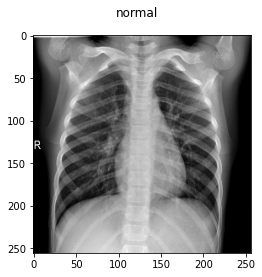

In [24]:
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

X_train = []
Y_train = []
# normal [1,0,0] , COVID-19 [0,1,0], Viral Pneumonia [0,0,1]

for i in (glob.glob(PATH+'/NORMAL/*')):
    img = cv2.imread(i) # Read image here
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(256,256))
    X_train.append(img)
    Y_train.append(np.array([1,0,0]))

fig = plt.figure()
fig.suptitle('normal')
plt.imshow(X_train[0], cmap='gray')    




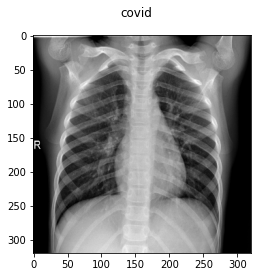

In [9]:



for i in (glob.glob(PATH + '/COVID-19/*')):
    img=cv2.imread(i) # Read image here
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(256,256))
    Y_train.append(np.array([0,1,0]))
    X_train.append(img)

fig = plt.figure()
fig.suptitle('covid')
plt.imshow(X_train[0], cmap='gray')

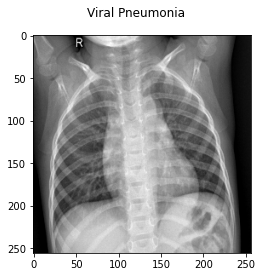

In [25]:
viral_images = []
for img_path in glob.glob(PATH + '/Viral Pneumonia/*'):
    img=cv2.imread(img_path) # Read image here
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(256,256))
    
    X_train.append(img)
    Y_train.append(np.array([0,0,1]))

fig = plt.figure()
fig.suptitle('Viral Pneumonia')
plt.imshow(X_train[1], cmap='gray')

In [26]:
'''
X = []
Y_train = []
cls_names = ["COVID-19/", "NORMAL/", "Viral Pneumonia/"]
# 0 refers to "COVID-19"
# 1 refers to NORMAL
# 2 refers to "Viral Pneumonia"
for cls_num in range(len(cls_names)):
    file_names = os.listdir(PATH + cls_names[cls_num])
    for fname in file_names:
        X.append(cls_names[cls_num] + fname)
        Y_train.append(cls_num)
Y_train = tf.keras.utils.to_categorical(Y)
X=np.array(X)
'''
X_train = np.array(X_train).reshape((-1,256,256,1))
Y_train = np.array(Y_train).reshape((-1,3))
print(X_train.shape)
print(Y_train.shape)


(2686, 256, 256, 1)
(2686, 3)


In [0]:
# Using 70% data for training, 15% for validating and 15% for testing
X_t, X_test, Y_t, Y_test = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 42)

In [0]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac


def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast (y_true, tf.float32)
    y_pred = tf.cast (y_pred, tf.float32)
    smooth = tf.cast (smooth, tf.float32)
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [0]:
def My_Model(epochs_num,savename):
  img_input = Input(shape= (IMG_W, IMG_H, CHANNELS))
  x=(Conv2D(8, (3, 3), padding='same', name='conv1'))(img_input)
  x=(BatchNormalization(name='bn1')(x))
  x=(Activation('relu')(x))
  x=(MaxPooling2D()(x))

  x=(Conv2D(16, (3, 3), padding='same', name='conv2'))(x)
  x=(BatchNormalization(name='bn2')(x))
  x=(Activation('relu')(x))
  x=(MaxPooling2D()(x))

  x=(Conv2D(32, (3, 3), padding='same', name='conv3'))(x)
  x=( BatchNormalization(name='bn3')(x))
  x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

  x=(Conv2D(16, (3, 3), padding='same', name='conv4'))(x)
  x=( BatchNormalization(name='bn4')(x))
  x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

  
  x=(Conv2D(32, (3, 3), padding='same', name='conv5'))(x)
  x=( BatchNormalization(name='bn5')(x))
  x=(Activation('relu')(x))
  x=(MaxPooling2D()(x))

  
  x=(Conv2D(64, (3, 3), padding='same', name='conv6'))(x)
  x=( BatchNormalization(name='bn6')(x))
  x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

  x=(Conv2D(32, (3, 3), padding='same', name='conv7'))(x)
  x=( BatchNormalization(name='bn7')(x))
  x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

  
  x=(Conv2D(64, (3, 3), padding='same', name='conv8'))(x)
  x=( BatchNormalization(name='bn8')(x))
  x=(Activation('relu')(x))
  x=(MaxPooling2D()(x))


  
  x=(Conv2D(128, (3, 3), padding='same', name='conv9'))(x)
  x=( BatchNormalization(name='bn9')(x))
  x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

  
  x=(Conv2D(64, (3, 3), padding='same', name='conv10'))(x)
  x=( BatchNormalization(name='bn10')(x))
  x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

  x=(Conv2D(128, (3, 3), padding='same', name='conv11'))(x)
  x=( BatchNormalization(name='bn11')(x))
  x=(Activation('relu')(x))
  x=(MaxPooling2D()(x))

  x=(Conv2D(256, (3, 3), padding='same', name='conv12'))(x)
  x=( BatchNormalization(name='bn12')(x))
  x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

  x=(Conv2D(128, (3, 3), padding='same', name='conv13'))(x)
  x=( BatchNormalization(name='bn13')(x))
  x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

  x=(Conv2D(256, (3, 3), padding='same', name='conv14'))(x)
  x=( BatchNormalization(name='bn14')(x))
  x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

  x=(Conv2D(128, (3, 3), padding='same', name='conv15'))(x)
  x=( BatchNormalization(name='bn15')(x))
  x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

  x=(Conv2D(256, (3, 3), padding='same', name='conv16'))(x)
  x=( BatchNormalization(name='bn16')(x))
  x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))
  
  x=(Conv2D(2, (3, 3), padding='same', name='conv17'))(x)
  x=( BatchNormalization(name='bn17')(x))
  x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))
  x=(Flatten())(x)
  x= Dense(3)(x)
  pred=(Activation('softmax')(x))
  #pred=Reshape((1,256,256,1))(x)
  model=Model(inputs=img_input, outputs=pred)
  model.compile(optimizer= Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False, decay=0.0001),
                  loss= ['categorical_crossentropy'],metrics=[iou, dice_coef,precision, recall,accuracy])#metrics=[iou, dice_coef,precision, recall,accuracy]
  history = model.fit(X_t,Y_t,BATCH_SIZE,epochs = epochs_num,validation_data=(X_valid,Y_valid),verbose=1)
  model.save(savename)
  return model,history


In [32]:
model, history = My_Model(5, 'My_Mod5.h5')

Train on 1880 samples, validate on 403 samples
Epoch 1/5
1880/1880 [==============================] - 193s 103ms/step - loss: 0.2845 - iou: 0.9984 - dice_coef: 0.8365 - precision: 0.8989 - recall: 0.8947 - accuracy: 0.9316 - val_loss: 0.3447 - val_iou: 0.9980 - val_dice_coef: 0.7915 - val_precision: 0.8669 - val_recall: 0.8603 - val_accuracy: 0.9093
Epoch 2/5
1880/1880 [==============================] - 193s 103ms/step - loss: 0.1808 - iou: 0.9990 - dice_coef: 0.8941 - precision: 0.9356 - recall: 0.9356 - accuracy: 0.9571 - val_loss: 0.2934 - val_iou: 0.9986 - val_dice_coef: 0.8778 - val_precision: 0.9163 - val_recall: 0.9142 - val_accuracy: 0.9436
Epoch 3/5
1880/1880 [==============================] - 191s 102ms/step - loss: 0.1478 - iou: 0.9992 - dice_coef: 0.9130 - precision: 0.9431 - recall: 0.9431 - accuracy: 0.9621 - val_loss: 0.4472 - val_iou: 0.9976 - val_dice_coef: 0.8293 - val_precision: 0.8415 - val_recall: 0.8415 - val_accuracy: 0.8943
Epoch 4/5
1880/1880 [=================

In [0]:
#Loading the model
img_input = Input(shape= (IMG_W, IMG_H, CHANNELS))
x=(Conv2D(8, (3, 3), padding='same', name='conv1'))(img_input)
x=(BatchNormalization(name='bn1')(x))
x=(Activation('relu')(x))
x=(MaxPooling2D()(x))

x=(Conv2D(16, (3, 3), padding='same', name='conv2'))(x)
x=(BatchNormalization(name='bn2')(x))
x=(Activation('relu')(x))
x=(MaxPooling2D()(x))

x=(Conv2D(32, (3, 3), padding='same', name='conv3'))(x)
x=( BatchNormalization(name='bn3')(x))
x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

x=(Conv2D(16, (3, 3), padding='same', name='conv4'))(x)
x=( BatchNormalization(name='bn4')(x))
x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

  
x=(Conv2D(32, (3, 3), padding='same', name='conv5'))(x)
x=( BatchNormalization(name='bn5')(x))
x=(Activation('relu')(x))
x=(MaxPooling2D()(x))

  
x=(Conv2D(64, (3, 3), padding='same', name='conv6'))(x)
x=( BatchNormalization(name='bn6')(x))
x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

x=(Conv2D(32, (3, 3), padding='same', name='conv7'))(x)
x=( BatchNormalization(name='bn7')(x))
x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

  
x=(Conv2D(64, (3, 3), padding='same', name='conv8'))(x)
x=( BatchNormalization(name='bn8')(x))
x=(Activation('relu')(x))
x=(MaxPooling2D()(x))


  
x=(Conv2D(128, (3, 3), padding='same', name='conv9'))(x)
x=( BatchNormalization(name='bn9')(x))
x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

  
x=(Conv2D(64, (3, 3), padding='same', name='conv10'))(x)
x=( BatchNormalization(name='bn10')(x))
x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

x=(Conv2D(128, (3, 3), padding='same', name='conv11'))(x)
x=( BatchNormalization(name='bn11')(x))
x=(Activation('relu')(x))
x=(MaxPooling2D()(x))

x=(Conv2D(256, (3, 3), padding='same', name='conv12'))(x)
x=( BatchNormalization(name='bn12')(x))
x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

x=(Conv2D(128, (3, 3), padding='same', name='conv13'))(x)
x=( BatchNormalization(name='bn13')(x))
x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

x=(Conv2D(256, (3, 3), padding='same', name='conv14'))(x)
x=( BatchNormalization(name='bn14')(x))
x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

x=(Conv2D(128, (3, 3), padding='same', name='conv15'))(x)
x=( BatchNormalization(name='bn15')(x))
x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))

x=(Conv2D(256, (3, 3), padding='same', name='conv16'))(x)
x=( BatchNormalization(name='bn16')(x))
x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))
  
x=(Conv2D(2, (3, 3), padding='same', name='conv17'))(x)
x=( BatchNormalization(name='bn17')(x))
x=(Activation('relu')(x))
  #x=(MaxPooling2D()(x))
x=(Flatten())(x)
x= Dense(3)(x)
pred=(Activation('softmax')(x))

In [0]:
model_0 = Model(inputs=img_input, outputs=pred)
model_0.compile(optimizer= Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False, decay=0.0005), loss= ['categorical_crossentropy'], metrics=[iou, dice_coef,precision, recall,accuracy])


In [0]:
model_0.load_weights('My_Mod5.h5')

In [40]:
print('\n~~~~~~~~~~~~~~~Stats after 5 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_0.evaluate(X_t, Y_t, batch_size= 10)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_0.evaluate(X_test, Y_test, batch_size= 10)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_0.evaluate(X_valid , Y_valid , batch_size= 10)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 5 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

1880/1880 [==============================] - 62s 33ms/step
________________________
IOU:       |   99.98  |
Dice Coef: |   96.56  |
Precision: |   98.78  |
Recall:    |   98.78  |
Accuracy:  |   99.18  |
Loss:      |   4.89  |
________________________

-------------On Test  Set--------------------------

403/403 [==============================] - 13s 32ms/step
________________________
IOU:       |   99.96  |
Dice Coef: |   95.48  |
Precision: |   97.80  |
Recall:    |   97.80  |
Accuracy:  |   98.54  |
Loss:      |   6.36  |
________________________

-------------On validation Set---------------------

403/403 [==============================] - 13s 31ms/step
________________________
IOU:       |   99.94  |
Dice Coef: |   94.55  |
Precision: |   95.85  |
Recall:    |   95.85  |
Accuracy:  |   97.24  |
Loss:      |   10.76  |
________________________


In [47]:
model, history = My_Model(epochs_num= 50, savename= ('My_Mod150.h5'))

Train on 1880 samples, validate on 403 samples
Epoch 1/50
1880/1880 [==============================] - 196s 104ms/step - loss: 0.2322 - iou: 0.9987 - dice_coef: 0.8625 - precision: 0.9073 - recall: 0.9032 - accuracy: 0.9374 - val_loss: 0.1995 - val_iou: 0.9989 - val_dice_coef: 0.9087 - val_precision: 0.9224 - val_recall: 0.9224 - val_accuracy: 0.9483
Epoch 2/50
1880/1880 [==============================] - 193s 103ms/step - loss: 0.1458 - iou: 0.9992 - dice_coef: 0.9206 - precision: 0.9489 - recall: 0.9489 - accuracy: 0.9660 - val_loss: 0.2089 - val_iou: 0.9989 - val_dice_coef: 0.8485 - val_precision: 0.9461 - val_recall: 0.9216 - val_accuracy: 0.9559
Epoch 3/50
1880/1880 [==============================] - 197s 105ms/step - loss: 0.1034 - iou: 0.9994 - dice_coef: 0.9408 - precision: 0.9649 - recall: 0.9649 - accuracy: 0.9766 - val_loss: 0.0766 - val_iou: 0.9995 - val_dice_coef: 0.9546 - val_precision: 0.9681 - val_recall: 0.9681 - val_accuracy: 0.9788
Epoch 4/50
1880/1880 [=============

In [0]:

model_1 = Model(inputs=img_input, outputs=pred)
model_1.compile(optimizer= Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False, decay=0.0005), loss= ['categorical_crossentropy'], metrics=[iou, dice_coef,precision, recall,accuracy])



In [0]:
model_1.load_weights('My_Mod150.h5')


In [50]:
print('\n~~~~~~~~~~~~~~~Stats after 150 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(X_t,Y_t, batch_size= 10)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(X_test, Y_test, batch_size= 10)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(X_valid, Y_valid, batch_size= 10)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 150 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

1880/1880 [==============================] - 57s 31ms/step
________________________
IOU:       |   100.00  |
Dice Coef: |   100.00  |
Precision: |   100.00  |
Recall:    |   100.00  |
Accuracy:  |   100.00  |
Loss:      |   0.00  |
________________________

-------------On Test  Set--------------------------

403/403 [==============================] - 12s 30ms/step
________________________
IOU:       |   99.95  |
Dice Coef: |   97.28  |
Precision: |   97.07  |
Recall:    |   97.07  |
Accuracy:  |   98.05  |
Loss:      |   12.50  |
________________________

-------------On validation Set---------------------

403/403 [==============================] - 12s 30ms/step
________________________
IOU:       |   99.98  |
Dice Coef: |   98.56  |
Precision: |   98.78  |
Recall:    |   98.78  |
Accuracy:  |   99.19  |
Loss:      |   10.36  |
________________________


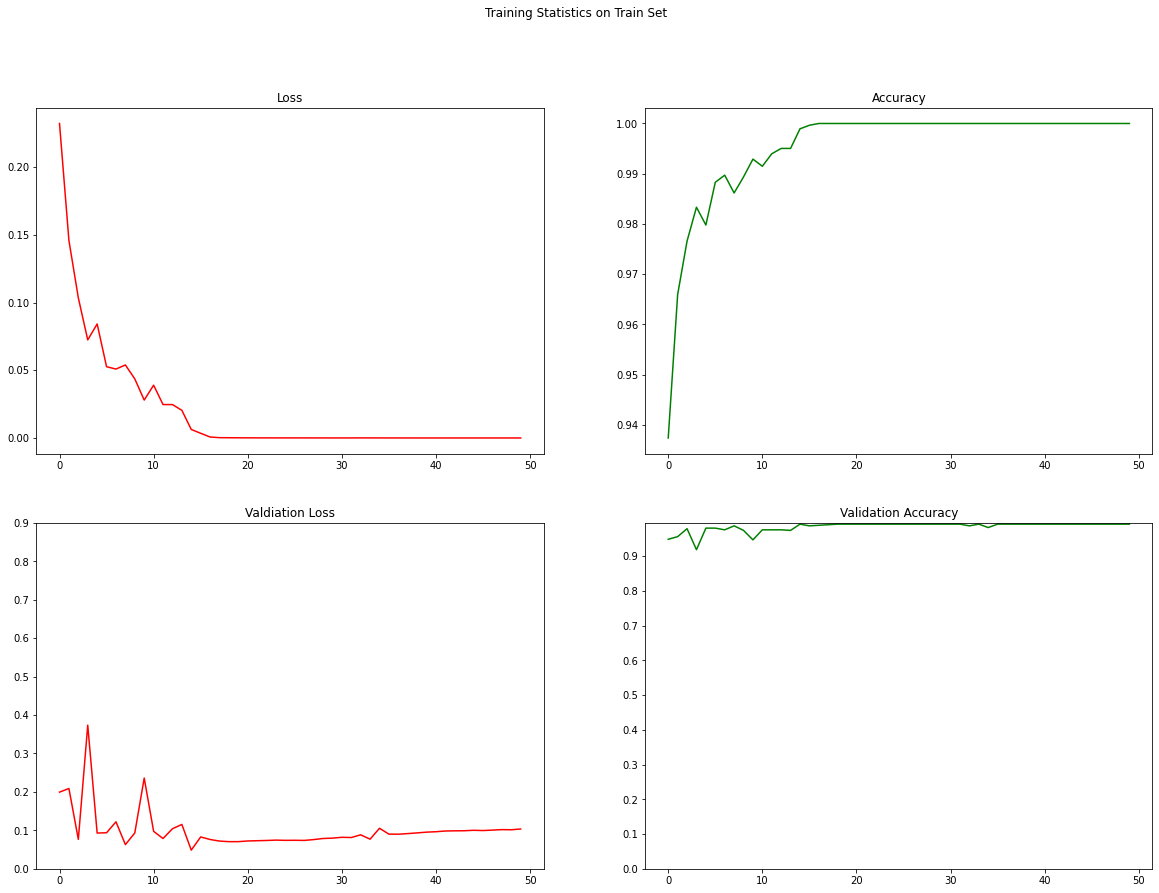

In [51]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(history.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(history.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

[1 0 0]
[[9.991665e-01 7.833763e-07 8.327097e-04]]


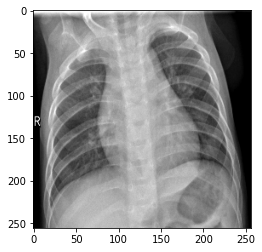

In [75]:
img_num = 49
img_pred = model_1.predict(X_test[img_num].reshape(-1,256,256,1))
plt.imshow(X_test[img_num].reshape(256,256), plt.cm.binary_r)
print(Y_test[img_num])
print(img_pred)



In [0]:
#Confusion Matrix
